# Import Libraries

In [3]:
import logging
import locale
import functools
import glob
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy.optimize import curve_fit, broyden1

import warnings
warnings.filterwarnings("ignore")

locale.setlocale(locale.LC_ALL, 'de_DE')

xticks = ["03-01", "03-15", "04-01", "04-15", "05-01", "05-15", "06-01"]

# Read "Our world in data" 

In [4]:
d1 = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

# Create index
d1["wrkDate"]=pd.to_datetime(d1.date)

# Functions

In [5]:
def ignoreException(func):
    @functools.wraps(func)
    def wrapper(*args, **kws):
        try:
            return func(*args, **kws)
        except:
            pass
    return wrapper

@ignoreException
def showGrows(location, variable, startDate, endDate, axes):
    variableName = variable.split("_")[1]
    wrk = d1[d1.location==location][d1.date > startDate][d1.date < endDate].copy()
    wrk.set_index(["wrkDate"], inplace=True)
    wrk["cum"] = wrk[variable].cumsum()
    
    wrk["smooth"] = wrk.cum.rolling(7).mean()
    #wrk = wrk[wrk.smooth > 5]
    wrk["diffY"] = wrk.smooth.diff()
    wrk["diffG"] = np.log(wrk.smooth).diff()
    #wrk["smooth"] = scipy.signal.savgol_filter(wrk[variable], 21, 5)
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1 = axes
    ax1.set_title("%s %s" % (location, variableName))
    ax1.set_yscale("log")
    ax1.set_xticklabels(xticks,rotation=20)
    ax1.set_ylabel("Total", color="b")
    ax1.tick_params(axis='y', labelcolor="b")
    ax1.plot(wrk.smooth)
    ax11 = ax1.twinx()
    ax11.set_yscale("log")
    ax11.set_ylabel("Growth", color="r")
    ax11.tick_params(axis='y', labelcolor="r")
    ax11.plot(wrk.diffG, color="r")
    
def showLocation(location, startDate, endDate):
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))
    fig.tight_layout(pad=6.5)
    showGrows(location, "new_cases", "2020-02-21", "2021-04-01", axes[0])
    showGrows(location, "new_cases", startDate, endDate, axes[1])
    showGrows(location, "new_deaths", "2020-02-21", "2021-04-01", axes[2])
    showGrows(location, "new_deaths", startDate, endDate, axes[3])

In [6]:
countriesOfInterest = ["Austria", "Belgium", "Denmark", "France", "Germany", "Italy",
                      "Norway", "Spain", "Sweden", "Switzerland", "United Kingdom"]

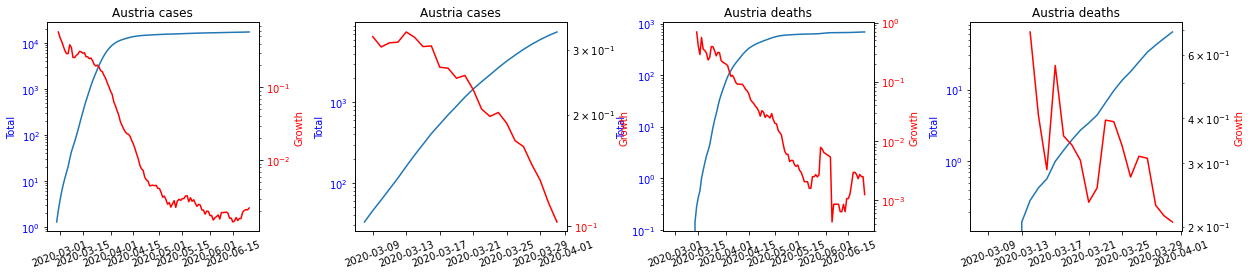

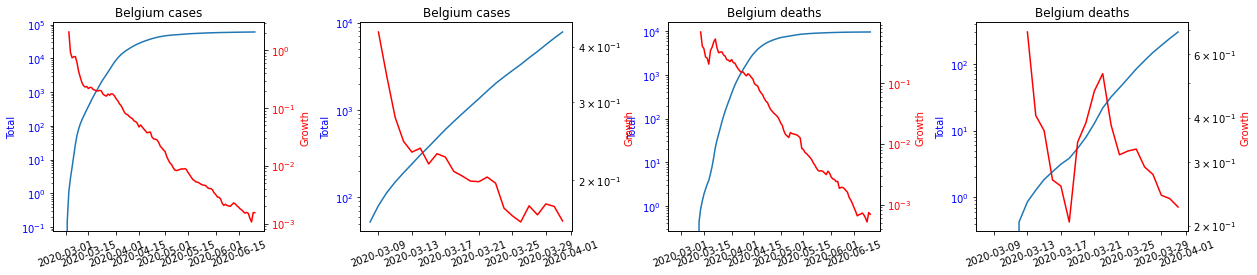

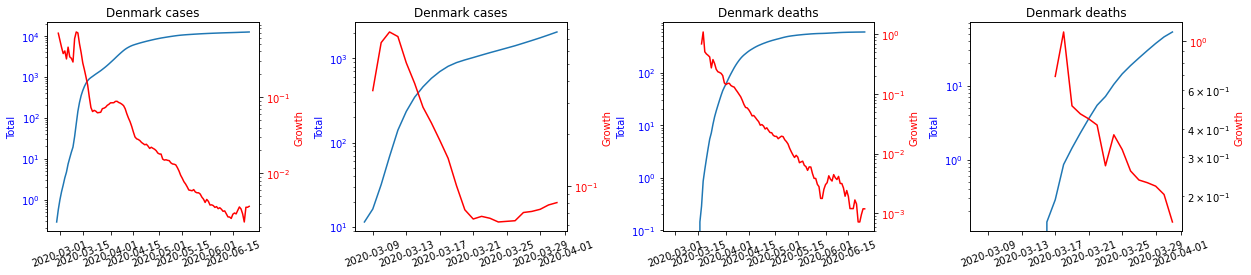

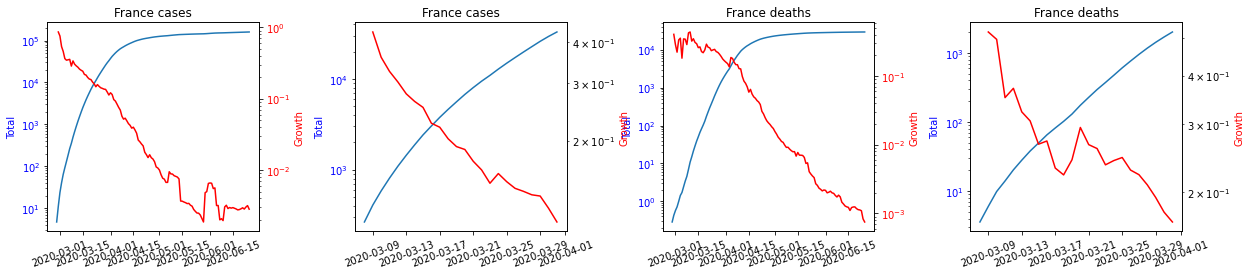

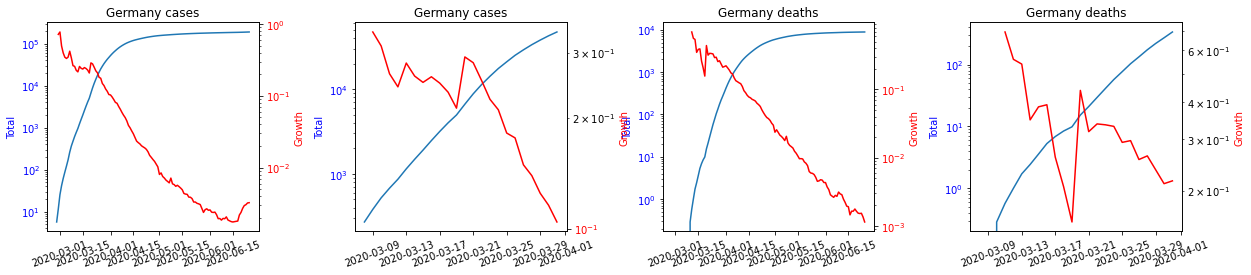

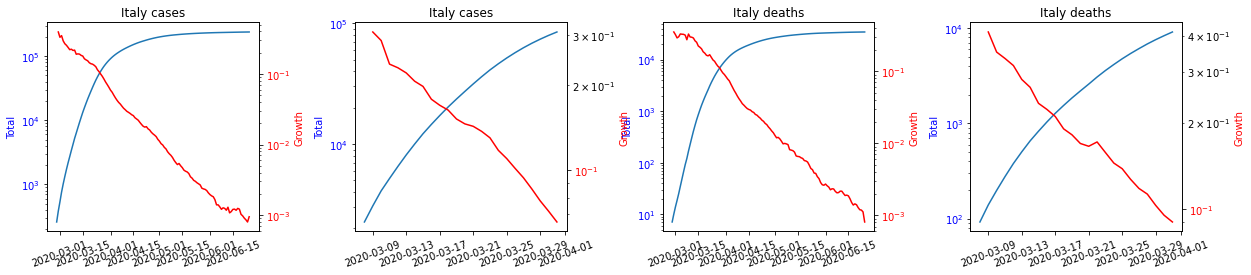

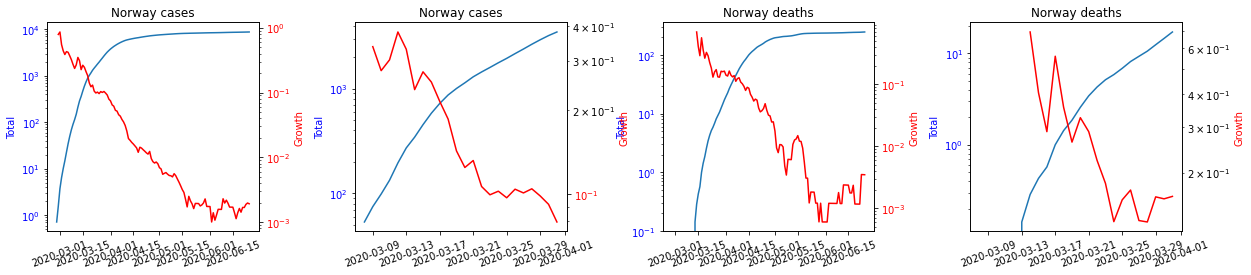

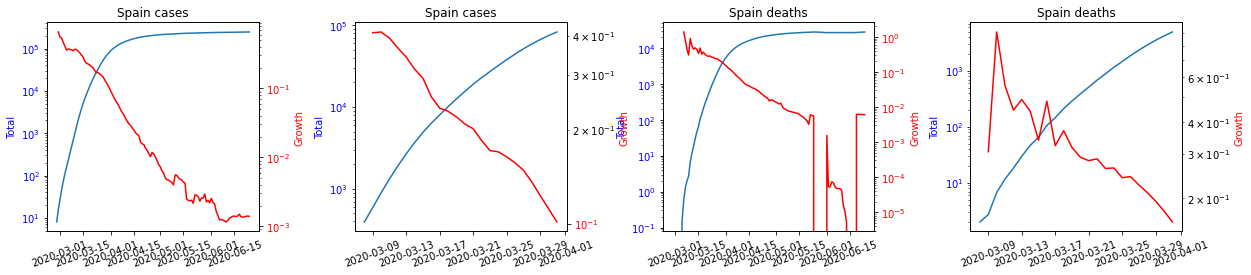

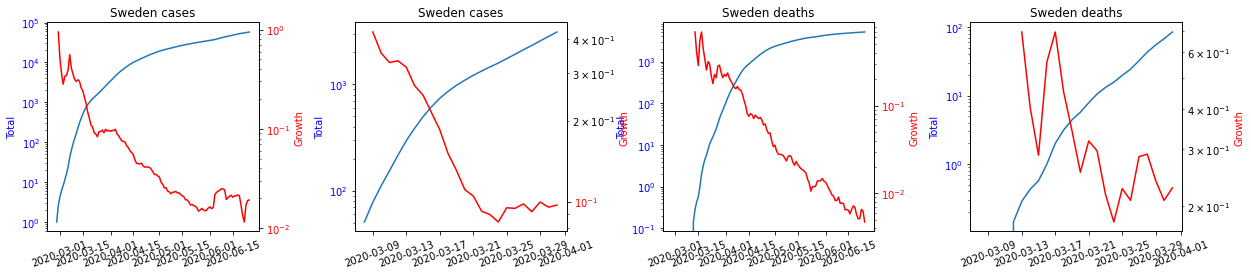

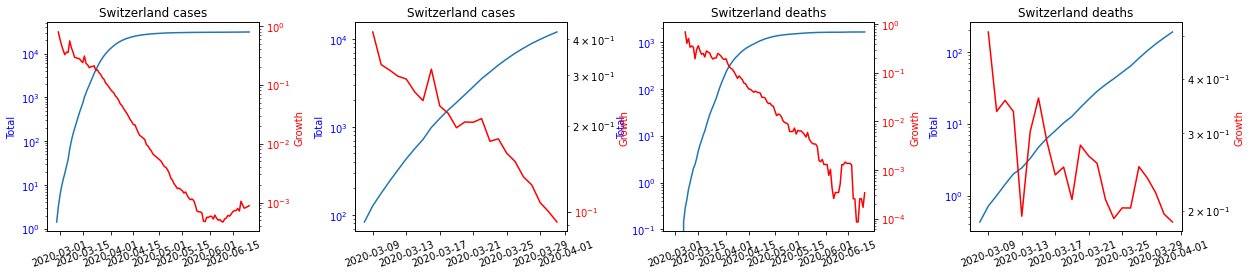

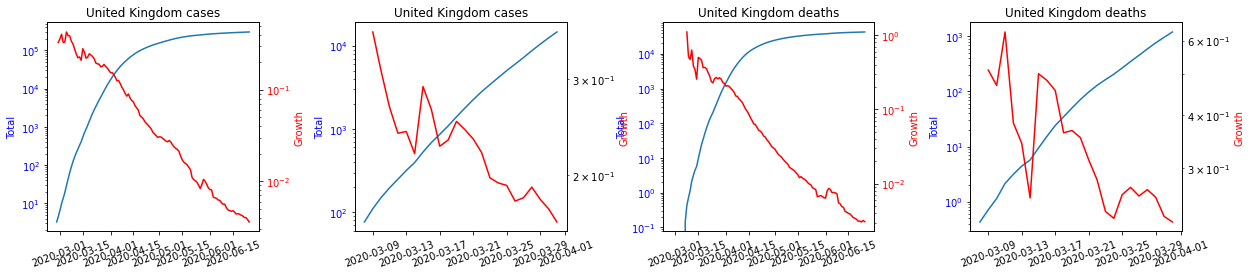

In [7]:
for location in countriesOfInterest:
    showLocation(location,  "2020-03-01", "2020-04-01")
    plt.show()


## Description

All input data is averaged over 7 day (rolling average), to correct weekly effects (weekends and public holidays) in reporting.

The the blue line shows the cummulative count (in log scale) in blue. The read line is the growth rate of the lue curve (in log scale). 
The 1st and 2rd graph show the confirmed cases, the 3rd and 4th graph the deaths.
The 1st and 3rd show the full time frame, while 2nd and 4th only show 2020-03.

You see that the blue graph is never a line (so growth is NOT exponential) (although it might look so in the 2nd and 4th graph).
You can also see no effect of lockdowns that occured mostly on 2020-03-23 and  would have to occur some time after it.

# Model

In [8]:
class Gompertz():
    def __init__(self):
        self.args = None
        self.end = 0 
    
    def compute(self, x):
        return self.gompertz_model(x, *self.args)
    
    def gompertz_model(self, x, a, b, c):
        return c*np.exp(-b*np.exp(-x/a)) # +c*d*x*x 
    
    def setY(self, y):
        self.y = y
        self.end = len(y)
    
    def fit(self):
        
        try:
            x = np.linspace(0, 1, self.end)
            p, e = curve_fit(self.gompertz_model, x, self.y[:self.end],  bounds=([0, -20, 50], [10, 20, 2e7]))
            if p[2]< 19.9e6:
                self.args = p
                self.day = x[1]
                return p
        except:
            pass
        return np.nan, np.nan, np.nan
    
    def remainingDays(self):
        ret = np.nan
        try:
            ret = (broyden1(self.computeEnd, 1.0) - 1.0)/ self.day
        except:
            pass
        return ret
        
    def computeEnd(self, x):
        return self.compute(x) - 0.95 * self.args[2]
    
    def func(self, x):
        self.end = x
        prediction = np.nan
        try:
            p = self.fit()
            prediction = p[2] - self.compute(1.0) + self.y[x] # + p[2]*p[3]
        except:
            pass
        self.end = len(self.y)
        return prediction


In [9]:
@ignoreException
def genLocation(location, variable, axes):
    variableName = variable.split("_")[1]
    print(location, variableName, end=" ")
    wrk = d1[d1.location==location].copy()
    wrk.set_index(["wrkDate"], inplace=True)
    wrk["cum"] = wrk[variable].cumsum()
    
    wrk["smooth"] = wrk.cum.rolling(7).mean()
    wrk = wrk[wrk.smooth > 5]
    wrk["diffY"] = wrk.smooth.diff()
    wrk["diffG"] = np.log(wrk.smooth).diff()
    #wrk["smooth"] = scipy.signal.savgol_filter(wrk[variable], 21, 5)
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1 = axes[0]
    ax2 = axes[1]
    ax1.set_title("%s %s" % (location, variableName))
    ax1.set_yscale("log")
    ax1.set_xticklabels(xticks,rotation=20)
    ax1.set_ylabel("Total", color="b")
    ax1.tick_params(axis='y', labelcolor="b")
    ax1.plot(wrk.smooth)
    ax11 = ax1.twinx()
    ax11.set_yscale("log")
    ax11.set_ylabel("Growth", color="r")
    ax11.tick_params(axis='y', labelcolor="r")
    ax11.plot(wrk.diffG, color="r")
   
    g = Gompertz()
    g.setY(wrk.smooth)
    p = g.fit()
    remainingDays = np.nan
    prediction = np.nan
    remaining = np.nan
    try:
        remainingDays = g.remainingDays()
        prediction = p[2] - g.compute(1.0) + max(wrk.cum) # + p[2]*p[3]
        remaining =  p[2] - g.compute(1.0)
    except:
        pass
    print(p, remaining, prediction, remainingDays)
    x = np.linspace(0, 1.0, len(wrk))
    y = np.vectorize(g.compute)(x)

    wrk["predict"] = pd.Series(y).values
    wrk["predictDiff"] = wrk.predict.diff()

    hist = wrk.smooth.values

    remainingStr = locale.format("%d", remaining, grouping=True)
    predictionStr = locale.format("%d", prediction, grouping=True)
    ax2.set_title("Fit: %s %s\n%s  %s  %.0f" % (location, variableName, remainingStr, predictionStr, remainingDays))
    ax2.set_yscale("log")
    ax2.set_ylabel("Daily", color="b")
    ax2.set_xticklabels(xticks,rotation=20)
    ax2.plot(wrk.diffY)
    ax2.plot(wrk.predictDiff, color="g")
    ax2.tick_params(axis='y', labelcolor="g")

    if len(hist) > 10:
        x=np.arange(10, len(wrk))+1

        y=None
        y=np.vectorize(g.func)(x)

        # Fill in missing values (5 data points minimum) and bring back to DataFrame
        wrk["maxPredict"] = pd.concat([pd.Series([ np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]), pd.Series(y)]).values

        ax21 = ax2.twinx()
        ax21.set_yscale("log")
        ax21.set_ylabel("Predicted Total", color="r")
        ax21.tick_params(axis='y', labelcolor="r")
        ax21.plot(wrk.maxPredict, color="r")


# Display functions

In [10]:
def analyzeTests(location, ax1):
    dx = d1[d1.location == location].copy()
    dx.set_index(["wrkDate"], inplace=True)
    dx["positive"] = dx.new_cases.rolling(7).mean() / dx.new_tests_smoothed.rolling(7).mean()
    
    
    ax1.set_title("Tests %s" % (location, ))

    ax1.set_xticklabels(xticks,rotation=20)
    dx["positive"] = dx.new_cases.rolling(7).mean() / dx.new_tests_smoothed.rolling(7).mean()
    ax1.set_ylabel("Daily Tests", color="b")
    ax1.tick_params(axis='y', labelcolor="b")

    ax1.plot(dx.new_tests_smoothed.rolling(7).mean())
    ax2 = ax1.twinx()
    ax2.set_ylabel("Positive rate", color="r")
    ax2.tick_params(axis='y', labelcolor="r")

    ax2.plot(dx.positive, color="r")
    
@ignoreException
def analyzeLocation(location):
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))
    fig.tight_layout(pad=6.5)
    genLocation(location, "new_cases", axes[0:2])
    genLocation(location, "new_deaths", axes[3:5])
    analyzeTests(location, axes[2])


# Run model

Austria cases [8.76239115e-02 1.45648393e+01 1.64318344e+04] 2.646123470967723 17386.646123470968 nan
Austria deaths [1.38029876e-01 4.28899352e+00 6.74095000e+02] 2.060779487025002 695.060779487025 -36.57028884283034


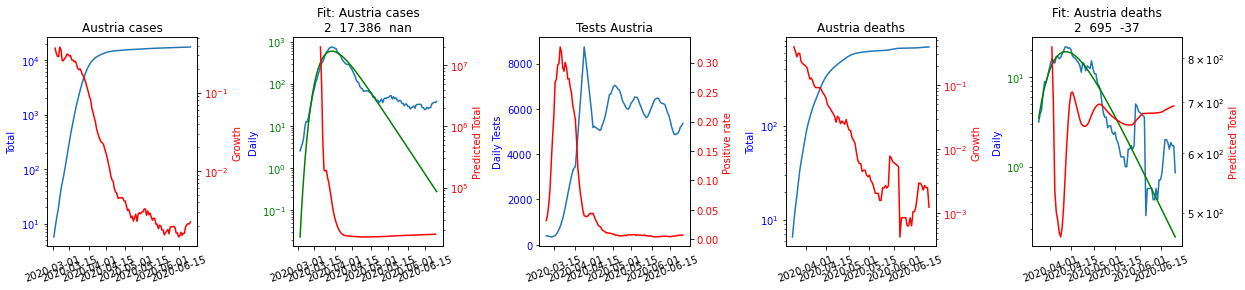

Belgium cases [1.38520373e-01 1.07490527e+01 6.02138463e+04] 472.19247861111216 61370.19247861111 -29.07596435082355
Belgium deaths [1.27259795e-01 9.42668657e+00 9.65361224e+03] 35.12344468251467 9757.123444682515 -32.97705175877588


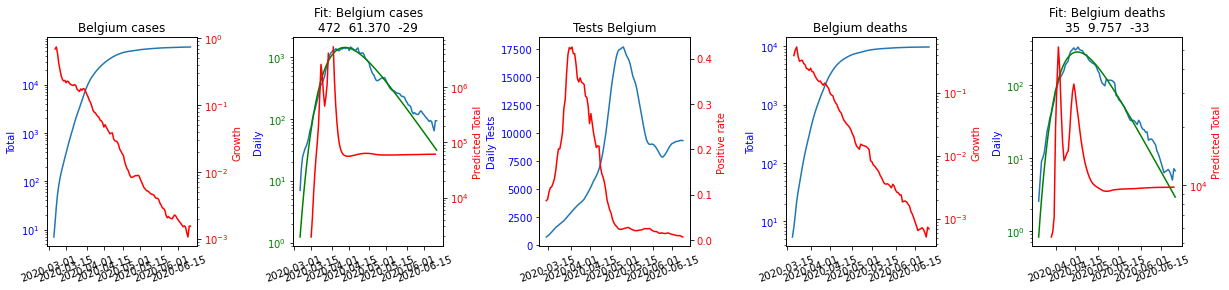

Denmark cases [1.81603209e-01 5.75134888e+00 1.25261846e+04] 289.12151293987154 12904.121512939872 -15.861911798327068
Denmark deaths [1.66993898e-01 3.99368529e+00 6.00172623e+02] 5.981581323340947 608.981581323341 -25.91188226766377


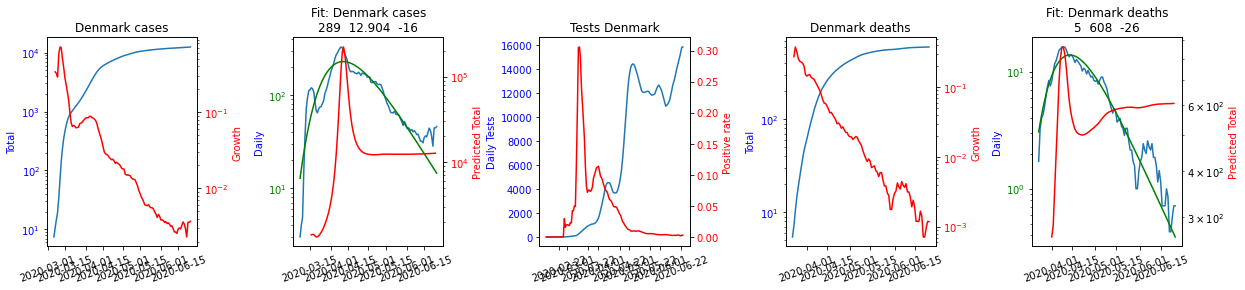

France cases [1.46494578e-01 2.00000000e+01 1.62743784e+05] 3493.4435143515293 164841.44351435153 -18.021427310890367
France deaths [1.15824872e-01 1.59839899e+01 2.92493518e+04] 83.10076068182389 29814.100760681824 -36.5105022809015


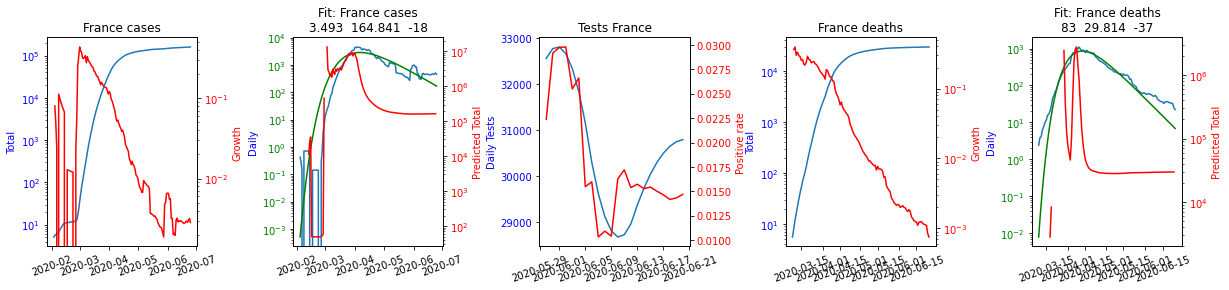

Germany cases [1.42150427e-01 2.00000000e+01 1.94689004e+05] 3399.2011603331484 195478.20116033315 -21.72754248037273
Germany deaths [1.49526802e-01 8.69219530e+00 8.92032244e+03] 96.09507125148048 9023.09507125148 -23.486098337190903


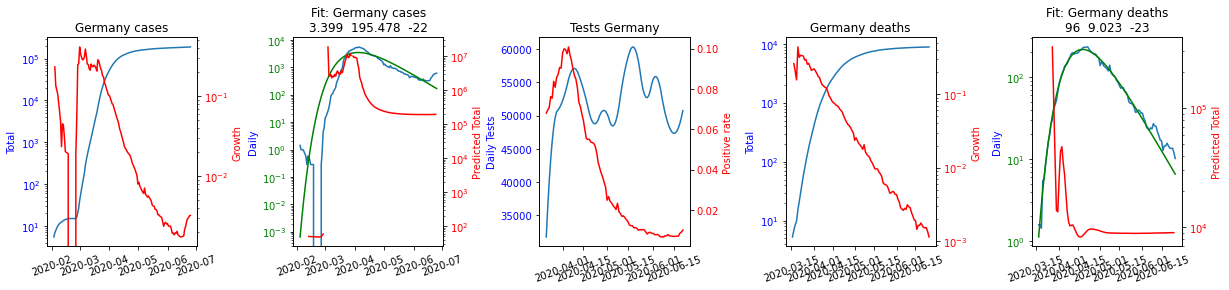

Italy cases [1.40141343e-01 9.10108937e+00 2.38523248e+05] 1722.1730533647642 241132.17305336476 -33.73466013727723
Italy deaths [1.51747851e-01 8.07366169e+00 3.46094133e+04] 381.86480429056974 35056.86480429057 -27.415838368309426


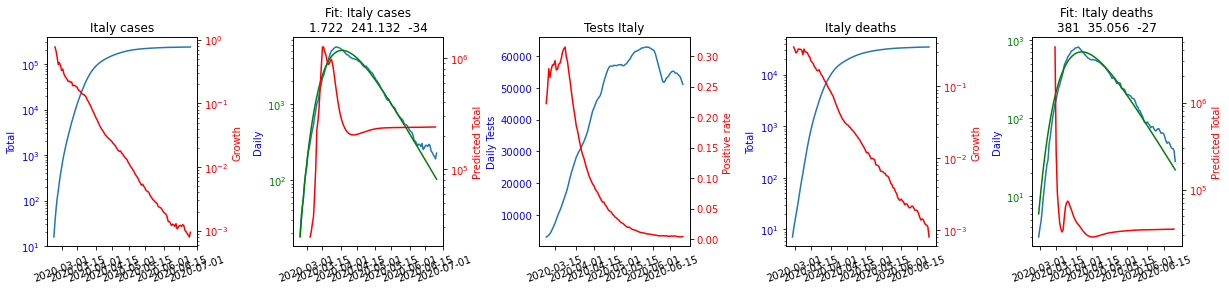

Norway cases [1.21444251e-01 7.14028942e+00 8.48621486e+03] 16.06709449858863 8793.067094498589 -46.064103975295595
Norway deaths [1.33771354e-01 5.42079429e+00 2.42224398e+02] 0.7431398442729744 249.74313984427297 -35.39729332247985


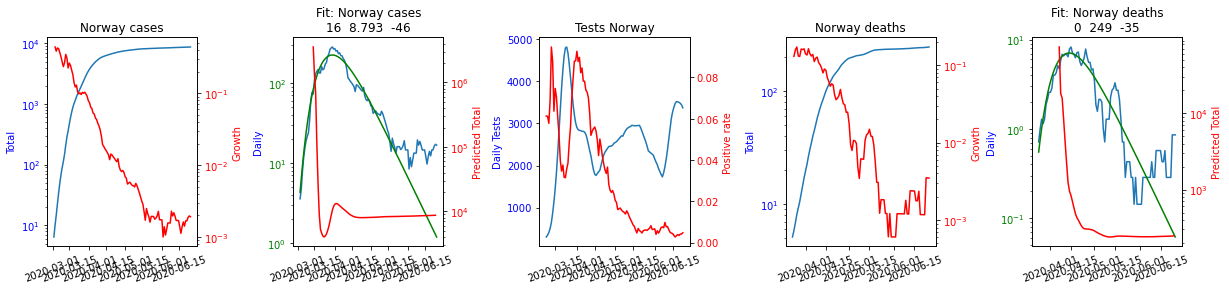

Spain cases [1.11450977e-01 1.34290411e+01 2.39828354e+05] 408.1733466911246 247494.17334669112 -44.779098582596326
Spain deaths [1.17883886e-01 9.23175937e+00 2.77667781e+04] 53.00394664681153 28805.00394664681 -41.11181000169674


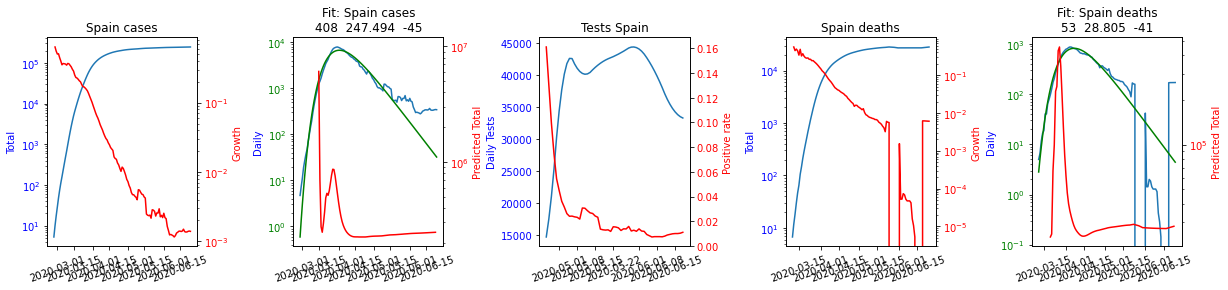

Sweden cases [4.89237921e-01 5.45865617e+00 1.12158606e+05] 56848.14328121672 119172.14328121672 148.8822924937084
Sweden deaths [2.35031850e-01 5.65335073e+00 5.41699299e+03] 417.7741026184267 5626.774102618427 10.206731554187337


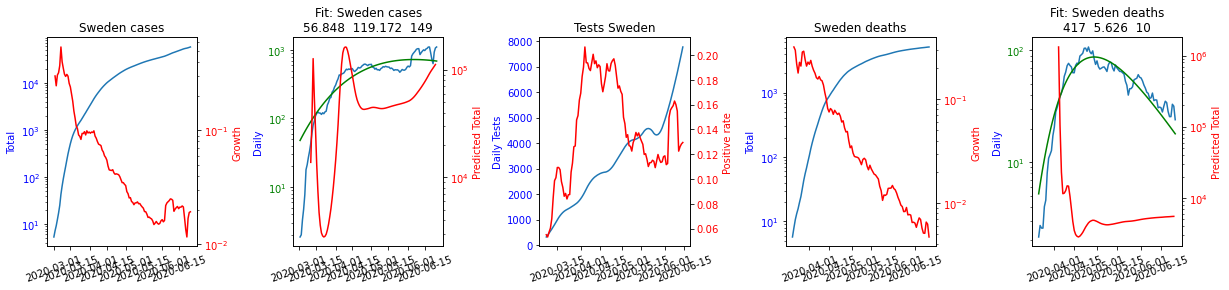

Switzerland cases [9.34265571e-02 1.48627914e+01 3.08436273e+04] 10.296300870133564 31303.296300870134 nan
Switzerland deaths [1.35585679e-01 6.41284287e+00 1.68662892e+03] 6.762357209096763 1687.7623572090968 -34.877807735720346


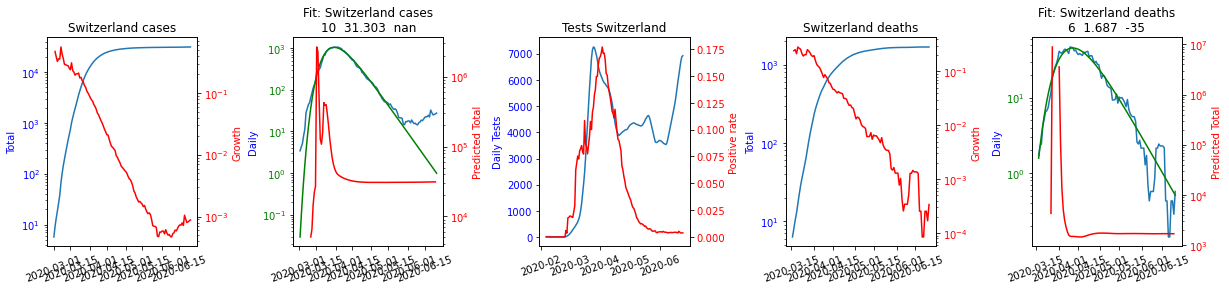

United Kingdom cases [1.77137098e-01 2.00000000e+01 3.27087906e+05] 22320.047326775675 329182.0473267757 7.5526830215189635
United Kingdom deaths [1.78654968e-01 7.72689728e+00 4.28219383e+04] 1209.3544958431376 44290.35449584314 -10.718461065971029


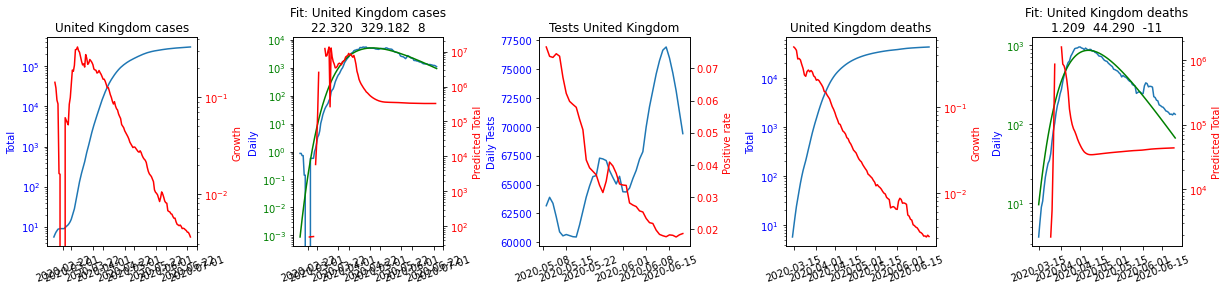

In [11]:
for location in countriesOfInterest:
    analyzeLocation(location)
    plt.show()

## Description

All input data is averaged over 7 days to adjust for weekends and public holidays.

The 1st and the 4th graph show the same information as previous.

The 2nd and 5th graph shows in blue the daily new cases/deaths (in log scale).
The green line is the Gompertz curve fit (with all data available) differentiated into daily values.
The red line is the plateu of the Gompertz curve (in log scale), when the curve is fit with only the data  to the point

The 3rd graph shows the num ebr of tests (per day) in blue.
The 3rd graph shows the positive test rate on that date.

You see, that the red line in the 1st and 4th graph are basically lines that flatten out (with some noise).
The red lines in the 2nd and 5th graph show, that the total numbers are now mostly stable  for a long time.

The numbers in the title in the 2nd and 4th graph are:
* Remaining numbber from today to plateau
* Plateau level
* Number of days from today until 95% of plateau is reached



In [234]:
with PdfPages("lockdown.pdf") as pdf:
      #for location in d1.location.unique():
      for location in countriesOfInterest:
            showLocation(location,  "2020-03-01", "2020-04-01")
            pdf.savefig()
            plt.close()

            analyzeLocation(location)
            pdf.savefig()
            plt.close()

Germany cases [1.43164370e-01 2.00000000e+01 1.94718418e+05] 3571.7871327048633 195020.78713270486 -20.716627427182956
Germany deaths [1.50870290e-01 8.70661085e+00 8.91663419e+03] 102.08383021789996 9016.0838302179 -22.539001194995176
Austria cases [8.80428703e-02 1.47022050e+01 1.64135874e+04] 2.817002319243329 17353.817002319243 nan
Austria deaths [1.39139817e-01 4.30087039e+00 6.73454565e+02] 2.187143937233145 695.1871439372331 -35.68856306883519
Italy cases [1.41189429e-01 9.11218213e+00 2.38456437e+05] 1817.1932957150857 240650.1932957151 -32.7772447571975
Italy deaths [1.52856703e-01 8.08912957e+00 3.45918079e+04] 401.0129975721211 35076.01299757212 -26.492962841306035
Spain cases [1.12120064e-01 1.35038036e+01 2.39628870e+05] 432.63929523085244 247184.63929523085 -43.89093551099403
Spain deaths [1.18849760e-01 9.25334097e+00 2.77534451e+04] 56.888316601121915 28808.888316601122 -40.16818192061701
France cases [1.47508305e-01 2.00000000e+01 1.62710184e+05] 3658.576587443502 1649

# PDF
Creates a PDF file with all the graphics

# Notes
The functions here were used with different data sources (ie IHME and JHU). They use data fields that can be easily derived from all of the datasets:
* location
* new_deaths
* new_cases
* wrkDate
* new_test_smoothed
* date